### Import libraries

In [1]:
import warnings

import numpy as np
import pandas as pd
import random
import torch
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [2]:
import sys
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ["USE_OPENMP"] = '1'

sys.path.append(os.path.abspath("../"))
from fe_modules.aggregates import get_agg_count, get_agg_sum, get_top_n_mode, \
                                  get_agg_mean, get_agg_max, get_agg_min, \
                                  get_agg_median, get_agg_std, get_agg_nunique, \
                                  get_price_of_all_cpes, get_ratio_part_of_day
from fe_modules.cyclical_features import generate_cyclical_features
from fe_modules.datetime_features import get_year, get_month, get_day, \
                                         get_timestamp, get_day_of_year, \
                                         get_day_of_week, get_holiday_name, \
                                         part_of_day_to_hour, add_hour_to_date, \
                                         get_relative_time, mean_first_visit, \
                                         mean_last_visit
from fe_modules.encoders import TargetEncoderWrapper
from fe_modules.feature_merges import add_cat_features
from fe_modules.geo_features import map_cities, geo_dist, dist_to_large_cities, \
                                    map_grid, MapGridTransformer, process_utc
from fe_modules.missing import map_prices
from fe_modules.preprocessing import clean_os_type
from fe_modules.text_manipulation import get_domain
from fe_modules.time_lags import generate_time_lags
from fe_modules.recsys_features import ALSWrapper

from fe_modules.user_fe import UserFE

from modules.memory_utils import pandas_reduce_mem_usage

In [3]:
def my_reset(*varnames):
    """
    varnames are what you want to keep
    """
    globals_ = globals()
    to_save = {v: globals_[v] for v in varnames}
    to_save['my_reset'] = my_reset  # lets keep this function by default
    del globals_
    get_ipython().magic("reset")
    globals().update(to_save)

In [4]:
random_state = 69

random.seed(random_state),
np.random.seed(random_state)
torch.manual_seed(random_state)
torch.cuda.manual_seed_all(random_state)

### Read Data

In [5]:
LOCAL_DATA = "../data"

In [6]:
df = pandas_reduce_mem_usage(
    pd.read_parquet(f'../10m.parquet')
)

Memory usage of dataframe is 963.21 MB


  0%|          | 0/14 [00:00<?, ?it/s]

Memory usage after optimization is: 963.21 MB
Decreased by 0.0%


In [6]:
# df = pandas_reduce_mem_usage( 
#         pd.read_parquet(f'context_data/competition_data_final_pqt/part-00000-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet')
# )
# df
df = pandas_reduce_mem_usage( 
        pd.read_parquet(f'{LOCAL_DATA}/competition_data_final_pqt')
)

targets = pandas_reduce_mem_usage( 
        pd.read_parquet(f'{LOCAL_DATA}/public_train.pqt')
) 

df = df.merge(targets, how="left", on="user_id")

df.head()

Memory usage of dataframe is 29562.33 MB


  0%|          | 0/12 [00:00<?, ?it/s]

Memory usage after optimization is: 26174.98 MB
Decreased by 11.5%
Memory usage of dataframe is 8.24 MB


  0%|          | 0/3 [00:00<?, ?it/s]

Memory usage after optimization is: 7.21 MB
Decreased by 12.5%


,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id,age,is_male
0,Краснодарский край,Краснодар,Apple,iPhone 7,ad.adriver.ru,smartphone,iOS,20368.0,2022-06-15,morning,1,45098,NaN,NaN
1,Краснодарский край,Краснодар,Apple,iPhone 7,apple.com,smartphone,iOS,20368.0,2022-06-19,morning,1,45098,NaN,NaN
2,Краснодарский край,Краснодар,Apple,iPhone 7,avatars.mds.yandex.net,smartphone,iOS,20368.0,2022-06-12,day,1,45098,NaN,NaN
3,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-16,day,1,45098,NaN,NaN
4,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-30,day,1,45098,NaN,NaN


In [7]:
df["is_male"] = df["is_male"].fillna(value=np.nan)
df.loc[df["is_male"] == "NA", "is_male"] = np.nan
df["is_male"] = df["is_male"].astype(np.float32)
df

,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id,age,is_male
0,Краснодарский край,Краснодар,Apple,iPhone 7,ad.adriver.ru,smartphone,iOS,20368.0,2022-06-15,morning,1,45098,NaN,NaN
1,Краснодарский край,Краснодар,Apple,iPhone 7,apple.com,smartphone,iOS,20368.0,2022-06-19,morning,1,45098,NaN,NaN
2,Краснодарский край,Краснодар,Apple,iPhone 7,avatars.mds.yandex.net,smartphone,iOS,20368.0,2022-06-12,day,1,45098,NaN,NaN
3,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-16,day,1,45098,NaN,NaN
4,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-30,day,1,45098,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999995,Ростовская область,Таганрог,Xiaomi,Redmi Note 8T,googleads.g.doubleclick.net,smartphone,Android,12544.0,2021-06-30,night,1,23799,NaN,NaN
9999996,Ростовская область,Таганрог,Xiaomi,Redmi Note 8T,vk.com,smartphone,Android,12544.0,2021-07-10,day,1,23799,NaN,NaN
9999997,Ростовская область,Таганрог,Xiaomi,Redmi Note 8T,vk.com,smartphone,Android,12544.0,2021-07-31,night,1,23799,NaN,NaN
9999998,Ростовская область,Таганрог,Xiaomi,Redmi Note 8T,yandex.ru,smartphone,Android,12544.0,2021-06-26,night,1,23799,NaN,NaN


In [8]:
userfe = UserFE()
userfe.load_df(df)

Memory usage of dataframe is 0.38 MB


  0%|          | 0/7 [00:00<?, ?it/s]

Memory usage after optimization is: 0.38 MB
Decreased by 0.0%


### Feature Engineering

In [9]:
my_reset("df", "userfe")

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [14]:
df = map_prices(df)
df = pandas_reduce_mem_usage(df)
df

Memory usage of dataframe is 32333.79 MB


  0%|          | 0/14 [00:00<?, ?it/s]

Memory usage after optimization is: 32333.79 MB
Decreased by 0.0%


,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id,age,is_male
0,Краснодарский край,Краснодар,Apple,iPhone 7,ad.adriver.ru,smartphone,iOS,20368.0,2022-06-15,morning,1,45098,NaN,NaN
1,Краснодарский край,Краснодар,Apple,iPhone 7,apple.com,smartphone,iOS,20368.0,2022-06-19,morning,1,45098,NaN,NaN
2,Краснодарский край,Краснодар,Apple,iPhone 7,avatars.mds.yandex.net,smartphone,iOS,20368.0,2022-06-12,day,1,45098,NaN,NaN
3,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-16,day,1,45098,NaN,NaN
4,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-30,day,1,45098,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322899430,Калужская область,Обнинск,Samsung,Galaxy A30s Dual,avatars.mds.yandex.net,smartphone,Android,16376.0,2021-07-12,morning,1,300964,57.0,0.0
322899431,Калужская область,Обнинск,Samsung,Galaxy A30s Dual,googleads.g.doubleclick.net,smartphone,Android,16376.0,2021-06-20,evening,1,300964,57.0,0.0
322899432,Калужская область,Обнинск,Samsung,Galaxy A30s Dual,online.sberbank.ru,smartphone,Android,16376.0,2021-08-05,day,1,300964,57.0,0.0
322899433,Калужская область,Обнинск,Samsung,Galaxy A30s Dual,s0.2mdn.net,smartphone,Android,16376.0,2021-07-19,evening,1,300964,57.0,0.0


In [15]:
userfe.get_agg(df, target_col="price", agg_name="mean", alias="mean_price")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 25.35 MB


  0%|          | 0/8 [00:00<?, ?it/s]

Memory usage after optimization is: 25.35 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0


In [16]:
userfe.get_agg(df, target_col="url_host", agg_name="count", alias="actions_number")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 28.52 MB


  0%|          | 0/9 [00:00<?, ?it/s]

Memory usage after optimization is: 26.14 MB
Decreased by 8.3%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313


In [9]:
userfe.get_agg(df, target_col="date", agg_name="nunique", alias="nunique_date")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 0.52 MB


  0%|          | 0/8 [00:00<?, ?it/s]

Memory usage after optimization is: 0.47 MB
Decreased by 10.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,nunique_date
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,117
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,32
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,51
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,113
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,15


In [17]:
userfe.get_agg(df, target_col="request_cnt", agg_name="sum", alias="request_sum")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 29.31 MB


  0%|          | 0/10 [00:00<?, ?it/s]

Memory usage after optimization is: 27.73 MB
Decreased by 5.4%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,request_sum
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,2261
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,1286
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,3306
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,2437
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,441


In [9]:
userfe.get_top_n_mode(df, target_col="url_host", n=5)
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 0.84 MB


  0%|          | 0/12 [00:00<?, ?it/s]

Memory usage after optimization is: 0.84 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,url_host_mode_0,url_host_mode_1,url_host_mode_2,url_host_mode_3,url_host_mode_4
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,apple.com,i.ytimg.com,googleads.g.doubleclick.net,icloud.com,avatars.mds.yandex.net
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,vk.com,sun9-27.userapi.com,sun9-32.userapi.com,ad.mail.ru,sun9-5.userapi.com
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,i.ytimg.com,yandex.ru,googleads.g.doubleclick.net,ad.mail.ru,vk.com
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,i.ytimg.com,googleads.g.doubleclick.net,yandex.ru,online.sberbank.ru,node1.online.sberbank.ru
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,yandex.ru,googleads.g.doubleclick.net,i.ytimg.com,avatars.mds.yandex.net,yastatic.net


In [10]:
userfe.get_ratio(df, ratio_col="url_host", n=5)
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 1.19 MB


  0%|          | 0/17 [00:00<?, ?it/s]

Memory usage after optimization is: 1.19 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,url_host_mode_0,url_host_mode_1,url_host_mode_2,url_host_mode_3,url_host_mode_4,url_host_ratio_0,url_host_ratio_1,url_host_ratio_2,url_host_ratio_3,url_host_ratio_4
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,apple.com,i.ytimg.com,googleads.g.doubleclick.net,icloud.com,avatars.mds.yandex.net,0.169032,0.148387,0.113548,0.108387,0.080645
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,vk.com,sun9-27.userapi.com,sun9-32.userapi.com,ad.mail.ru,sun9-5.userapi.com,0.084488,0.069252,0.067867,0.066482,0.059557
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,i.ytimg.com,yandex.ru,googleads.g.doubleclick.net,ad.mail.ru,vk.com,0.102141,0.097859,0.088073,0.074006,0.051988
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,i.ytimg.com,googleads.g.doubleclick.net,yandex.ru,online.sberbank.ru,node1.online.sberbank.ru,0.145223,0.115287,0.084713,0.074522,0.067516
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,yandex.ru,googleads.g.doubleclick.net,i.ytimg.com,avatars.mds.yandex.net,yastatic.net,0.079872,0.073482,0.057508,0.054313,0.047923


In [19]:
userfe.get_ratio_part_of_day(df)
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 57.83 MB


  0%|          | 0/19 [00:00<?, ?it/s]

Memory usage after optimization is: 57.83 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,request_sum,url_host_mode_0,url_host_mode_1,url_host_mode_2,url_host_mode_3,url_host_mode_4,morning,day,evening,night
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,2261,apple.com,i.ytimg.com,googleads.g.doubleclick.net,icloud.com,avatars.mds.yandex.net,0.254839,0.349677,0.287742,0.107742
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,1286,vk.com,sun9-27.userapi.com,sun9-32.userapi.com,ad.mail.ru,sun9-5.userapi.com,0.227147,0.412742,0.357341,0.002770
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,3306,i.ytimg.com,yandex.ru,googleads.g.doubleclick.net,ad.mail.ru,vk.com,0.211621,0.358410,0.320489,0.109480
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,2437,i.ytimg.com,googleads.g.doubleclick.net,yandex.ru,online.sberbank.ru,node1.online.sberbank.ru,0.215287,0.350955,0.328025,0.105732
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,441,yandex.ru,googleads.g.doubleclick.net,i.ytimg.com,avatars.mds.yandex.net,yastatic.net,0.562300,0.207668,0.204473,0.025559


In [11]:
userfe.get_top_n_mode(df, target_col="region_name", n=3)
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 1.40 MB


  0%|          | 0/20 [00:00<?, ?it/s]

Memory usage after optimization is: 1.40 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,url_host_mode_0,url_host_mode_1,url_host_mode_2,url_host_mode_3,url_host_mode_4,url_host_ratio_0,url_host_ratio_1,url_host_ratio_2,url_host_ratio_3,url_host_ratio_4,region_name_mode_0,region_name_mode_1,region_name_mode_2
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,apple.com,i.ytimg.com,googleads.g.doubleclick.net,icloud.com,avatars.mds.yandex.net,0.169032,0.148387,0.113548,0.108387,0.080645,Краснодарский край,Ставропольский край,Республика Адыгея
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,vk.com,sun9-27.userapi.com,sun9-32.userapi.com,ad.mail.ru,sun9-5.userapi.com,0.084488,0.069252,0.067867,0.066482,0.059557,Санкт-Петербург,<blank>,<blank>
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,i.ytimg.com,yandex.ru,googleads.g.doubleclick.net,ad.mail.ru,vk.com,0.102141,0.097859,0.088073,0.074006,0.051988,Санкт-Петербург,Калининградская область,<blank>
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,i.ytimg.com,googleads.g.doubleclick.net,yandex.ru,online.sberbank.ru,node1.online.sberbank.ru,0.145223,0.115287,0.084713,0.074522,0.067516,Краснодарский край,<blank>,<blank>
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,yandex.ru,googleads.g.doubleclick.net,i.ytimg.com,avatars.mds.yandex.net,yastatic.net,0.079872,0.073482,0.057508,0.054313,0.047923,Тюменская область,Свердловская область,<blank>


In [12]:
userfe.get_ratio(df, ratio_col="region_name", n=3)
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 1.61 MB


  0%|          | 0/23 [00:00<?, ?it/s]

Memory usage after optimization is: 1.61 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,url_host_mode_0,url_host_mode_1,url_host_mode_2,...,url_host_ratio_1,url_host_ratio_2,url_host_ratio_3,url_host_ratio_4,region_name_mode_0,region_name_mode_1,region_name_mode_2,region_name_ratio_0,region_name_ratio_1,region_name_ratio_2
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,apple.com,i.ytimg.com,googleads.g.doubleclick.net,...,0.148387,0.113548,0.108387,0.080645,Краснодарский край,Ставропольский край,Республика Адыгея,0.995484,0.003871,0.000645
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,vk.com,sun9-27.userapi.com,sun9-32.userapi.com,...,0.069252,0.067867,0.066482,0.059557,Санкт-Петербург,<blank>,<blank>,1.0,0.0,0.0
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,i.ytimg.com,yandex.ru,googleads.g.doubleclick.net,...,0.097859,0.088073,0.074006,0.051988,Санкт-Петербург,Калининградская область,<blank>,0.937615,0.062385,0.0
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,i.ytimg.com,googleads.g.doubleclick.net,yandex.ru,...,0.115287,0.084713,0.074522,0.067516,Краснодарский край,<blank>,<blank>,1.0,0.0,0.0
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,yandex.ru,googleads.g.doubleclick.net,i.ytimg.com,...,0.073482,0.057508,0.054313,0.047923,Тюменская область,Свердловская область,<blank>,0.99361,0.00639,0.0


In [13]:
userfe.get_top_n_mode(df, target_col="city_name", n=3)
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 1.82 MB


  0%|          | 0/26 [00:00<?, ?it/s]

Memory usage after optimization is: 1.82 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,url_host_mode_0,url_host_mode_1,url_host_mode_2,...,url_host_ratio_4,region_name_mode_0,region_name_mode_1,region_name_mode_2,region_name_ratio_0,region_name_ratio_1,region_name_ratio_2,city_name_mode_0,city_name_mode_1,city_name_mode_2
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,apple.com,i.ytimg.com,googleads.g.doubleclick.net,...,0.080645,Краснодарский край,Ставропольский край,Республика Адыгея,0.995484,0.003871,0.000645,Краснодар,Ставрополь,Адыгейск
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,vk.com,sun9-27.userapi.com,sun9-32.userapi.com,...,0.059557,Санкт-Петербург,<blank>,<blank>,1.0,0.0,0.0,Санкт-Петербург,<blank>,<blank>
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,i.ytimg.com,yandex.ru,googleads.g.doubleclick.net,...,0.051988,Санкт-Петербург,Калининградская область,<blank>,0.937615,0.062385,0.0,Санкт-Петербург,Калининград,<blank>
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,i.ytimg.com,googleads.g.doubleclick.net,yandex.ru,...,0.067516,Краснодарский край,<blank>,<blank>,1.0,0.0,0.0,Новороссийск,<blank>,<blank>
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,yandex.ru,googleads.g.doubleclick.net,i.ytimg.com,...,0.047923,Тюменская область,Свердловская область,<blank>,0.99361,0.00639,0.0,Тюмень,Екатеринбург,<blank>


In [14]:
userfe.get_ratio(df, ratio_col="city_name", n=3)
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 2.03 MB


  0%|          | 0/29 [00:00<?, ?it/s]

Memory usage after optimization is: 2.03 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,url_host_mode_0,url_host_mode_1,url_host_mode_2,...,region_name_mode_2,region_name_ratio_0,region_name_ratio_1,region_name_ratio_2,city_name_mode_0,city_name_mode_1,city_name_mode_2,city_name_ratio_0,city_name_ratio_1,city_name_ratio_2
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,apple.com,i.ytimg.com,googleads.g.doubleclick.net,...,Республика Адыгея,0.995484,0.003871,0.000645,Краснодар,Ставрополь,Адыгейск,0.995484,0.002581,0.000645
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,vk.com,sun9-27.userapi.com,sun9-32.userapi.com,...,<blank>,1.0,0.0,0.0,Санкт-Петербург,<blank>,<blank>,1.0,0.0,0.0
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,i.ytimg.com,yandex.ru,googleads.g.doubleclick.net,...,<blank>,0.937615,0.062385,0.0,Санкт-Петербург,Калининград,<blank>,0.937615,0.062385,0.0
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,i.ytimg.com,googleads.g.doubleclick.net,yandex.ru,...,<blank>,1.0,0.0,0.0,Новороссийск,<blank>,<blank>,1.0,0.0,0.0
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,yandex.ru,googleads.g.doubleclick.net,i.ytimg.com,...,<blank>,0.99361,0.00639,0.0,Тюмень,Екатеринбург,<blank>,0.99361,0.00639,0.0


In [22]:
userfe.get_agg(df, target_col="request_cnt", agg_name="mean", alias="mean_request_cnt")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 80.01 MB


  0%|          | 0/26 [00:00<?, ?it/s]

Memory usage after optimization is: 80.01 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,request_sum,...,day,evening,night,region_name_mode_0,region_name_mode_1,region_name_mode_2,city_name_mode_0,city_name_mode_1,city_name_mode_2,mean_request_cnt
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,2261,...,0.349677,0.287742,0.107742,Краснодарский край,Ставропольский край,Республика Адыгея,Краснодар,Ставрополь,Адыгейск,1.458710
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,1286,...,0.412742,0.357341,0.002770,Санкт-Петербург,<blank>,<blank>,Санкт-Петербург,<blank>,<blank>,1.781163
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,3306,...,0.358410,0.320489,0.109480,Санкт-Петербург,Калининградская область,<blank>,Санкт-Петербург,Калининград,<blank>,2.022018
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,2437,...,0.350955,0.328025,0.105732,Краснодарский край,<blank>,<blank>,Новороссийск,<blank>,<blank>,1.552229
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,441,...,0.207668,0.204473,0.025559,Тюменская область,Свердловская область,<blank>,Тюмень,Екатеринбург,<blank>,1.408946


In [10]:
df = part_of_day_to_hour(df)
df = add_hour_to_date(df)
df = get_timestamp(df)
# df = get_relative_time(df)
df = pandas_reduce_mem_usage(df)
df

Memory usage of dataframe is 1153.95 MB


  0%|          | 0/17 [00:00<?, ?it/s]

Memory usage after optimization is: 1153.95 MB
Decreased by 0.0%


,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id,age,is_male,hour,datetime,timestamp
0,Краснодарский край,Краснодар,Apple,iPhone 7,ad.adriver.ru,smartphone,iOS,20368.0,2022-06-15,morning,1,45098,NaN,NaN,0 days 09:00:00,2022-06-15 09:00:00,165528360.0
1,Краснодарский край,Краснодар,Apple,iPhone 7,apple.com,smartphone,iOS,20368.0,2022-06-19,morning,1,45098,NaN,NaN,0 days 09:00:00,2022-06-19 09:00:00,165562920.0
2,Краснодарский край,Краснодар,Apple,iPhone 7,avatars.mds.yandex.net,smartphone,iOS,20368.0,2022-06-12,day,1,45098,NaN,NaN,0 days 15:00:00,2022-06-12 15:00:00,165504600.0
3,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-16,day,1,45098,NaN,NaN,0 days 15:00:00,2022-05-16 15:00:00,165271320.0
4,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-30,day,1,45098,NaN,NaN,0 days 15:00:00,2022-05-30 15:00:00,165392280.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999995,Ростовская область,Таганрог,Xiaomi,Redmi Note 8T,googleads.g.doubleclick.net,smartphone,Android,12544.0,2021-06-30,night,1,23799,NaN,NaN,0 days 03:00:00,2021-06-30 03:00:00,162502200.0
9999996,Ростовская область,Таганрог,Xiaomi,Redmi Note 8T,vk.com,smartphone,Android,12544.0,2021-07-10,day,1,23799,NaN,NaN,0 days 15:00:00,2021-07-10 15:00:00,162592920.0
9999997,Ростовская область,Таганрог,Xiaomi,Redmi Note 8T,vk.com,smartphone,Android,12544.0,2021-07-31,night,1,23799,NaN,NaN,0 days 03:00:00,2021-07-31 03:00:00,162770040.0
9999998,Ростовская область,Таганрог,Xiaomi,Redmi Note 8T,yandex.ru,smartphone,Android,12544.0,2021-06-26,night,1,23799,NaN,NaN,0 days 03:00:00,2021-06-26 03:00:00,162467640.0


In [24]:
userfe.get_timespan(df, date_col="datetime")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 83.18 MB


  0%|          | 0/27 [00:00<?, ?it/s]

Memory usage after optimization is: 83.18 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,request_sum,...,evening,night,region_name_mode_0,region_name_mode_1,region_name_mode_2,city_name_mode_0,city_name_mode_1,city_name_mode_2,mean_request_cnt,timespan
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,2261,...,0.287742,0.107742,Краснодарский край,Ставропольский край,Республика Адыгея,Краснодар,Ставрополь,Адыгейск,1.458710,100872.0
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,1286,...,0.357341,0.002770,Санкт-Петербург,<blank>,<blank>,Санкт-Петербург,<blank>,<blank>,1.781163,61776.0
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,3306,...,0.320489,0.109480,Санкт-Петербург,Калининградская область,<blank>,Санкт-Петербург,Калининград,<blank>,2.022018,43200.0
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,2437,...,0.328025,0.105732,Краснодарский край,<blank>,<blank>,Новороссийск,<blank>,<blank>,1.552229,100656.0
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,441,...,0.204473,0.025559,Тюменская область,Свердловская область,<blank>,Тюмень,Екатеринбург,<blank>,1.408946,15120.0


In [25]:
userfe.get_ratio_request_timespan()
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 86.34 MB


  0%|          | 0/28 [00:00<?, ?it/s]

Memory usage after optimization is: 86.34 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,request_sum,...,night,region_name_mode_0,region_name_mode_1,region_name_mode_2,city_name_mode_0,city_name_mode_1,city_name_mode_2,mean_request_cnt,timespan,ratio_request_timespan
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,2261,...,0.107742,Краснодарский край,Ставропольский край,Республика Адыгея,Краснодар,Ставрополь,Адыгейск,1.458710,100872.0,0.022415
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,1286,...,0.002770,Санкт-Петербург,<blank>,<blank>,Санкт-Петербург,<blank>,<blank>,1.781163,61776.0,0.020817
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,3306,...,0.109480,Санкт-Петербург,Калининградская область,<blank>,Санкт-Петербург,Калининград,<blank>,2.022018,43200.0,0.076528
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,2437,...,0.105732,Краснодарский край,<blank>,<blank>,Новороссийск,<blank>,<blank>,1.552229,100656.0,0.024211
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,441,...,0.025559,Тюменская область,Свердловская область,<blank>,Тюмень,Екатеринбург,<blank>,1.408946,15120.0,0.029167


In [11]:
userfe.get_first_visit_sec(df)
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 0.52 MB


  0%|          | 0/8 [00:00<?, ?it/s]

Memory usage after optimization is: 0.52 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,first_visit_sec
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,16455852.0
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,16238340.0
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,16293636.0
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,16455852.0
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,16243524.0


In [26]:
userfe.get_agg(df, target_col="region_name", agg_name="nunique", alias="nunique_region_name")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 89.51 MB


  0%|          | 0/29 [00:00<?, ?it/s]

Memory usage after optimization is: 86.74 MB
Decreased by 3.1%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,request_sum,...,region_name_mode_0,region_name_mode_1,region_name_mode_2,city_name_mode_0,city_name_mode_1,city_name_mode_2,mean_request_cnt,timespan,ratio_request_timespan,nunique_region_name
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,2261,...,Краснодарский край,Ставропольский край,Республика Адыгея,Краснодар,Ставрополь,Адыгейск,1.458710,100872.0,0.022415,3
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,1286,...,Санкт-Петербург,<blank>,<blank>,Санкт-Петербург,<blank>,<blank>,1.781163,61776.0,0.020817,1
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,3306,...,Санкт-Петербург,Калининградская область,<blank>,Санкт-Петербург,Калининград,<blank>,2.022018,43200.0,0.076528,2
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,2437,...,Краснодарский край,<blank>,<blank>,Новороссийск,<blank>,<blank>,1.552229,100656.0,0.024211,1
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,441,...,Тюменская область,Свердловская область,<blank>,Тюмень,Екатеринбург,<blank>,1.408946,15120.0,0.029167,2


In [27]:
userfe.get_agg(df, target_col="city_name", agg_name="nunique", alias="nunique_city_name")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 89.91 MB


  0%|          | 0/30 [00:00<?, ?it/s]

Memory usage after optimization is: 87.14 MB
Decreased by 3.1%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,request_sum,...,region_name_mode_1,region_name_mode_2,city_name_mode_0,city_name_mode_1,city_name_mode_2,mean_request_cnt,timespan,ratio_request_timespan,nunique_region_name,nunique_city_name
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,2261,...,Ставропольский край,Республика Адыгея,Краснодар,Ставрополь,Адыгейск,1.458710,100872.0,0.022415,3,5
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,1286,...,<blank>,<blank>,Санкт-Петербург,<blank>,<blank>,1.781163,61776.0,0.020817,1,1
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,3306,...,Калининградская область,<blank>,Санкт-Петербург,Калининград,<blank>,2.022018,43200.0,0.076528,2,2
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,2437,...,<blank>,<blank>,Новороссийск,<blank>,<blank>,1.552229,100656.0,0.024211,1,1
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,441,...,Свердловская область,<blank>,Тюмень,Екатеринбург,<blank>,1.408946,15120.0,0.029167,2,2


In [5]:
FE_DATA = "../fe_data/"

In [36]:
userfe.df.to_parquet(f"{FE_DATA}/USER_FE_BEFORE_ALS_v1.parquet.gzip",
              compression='gzip')

df.to_parquet(f"{FE_DATA}/DF_BEFORE_ALS_v1.parquet.gzip",
              compression='gzip')

In [6]:
df = pandas_reduce_mem_usage(pd.read_parquet(f"{FE_DATA}/DF_BEFORE_ALS_v1.parquet.gzip"))
userfe = UserFE()
userfe.load(f"{FE_DATA}/USER_FE_BEFORE_ALS_v1.parquet.gzip")
userfe.df.head()

Memory usage of dataframe is 39724.38 MB


  0%|          | 0/17 [00:00<?, ?it/s]

Memory usage after optimization is: 39724.38 MB
Decreased by 0.0%
Memory usage of dataframe is 85.55 MB


  0%|          | 0/30 [00:00<?, ?it/s]

Memory usage after optimization is: 85.55 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,request_sum,...,region_name_mode_1,region_name_mode_2,city_name_mode_0,city_name_mode_1,city_name_mode_2,mean_request_cnt,timespan,ratio_request_timespan,nunique_region_name,nunique_city_name
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,2261,...,Ставропольский край,Республика Адыгея,Краснодар,Ставрополь,Адыгейск,1.458710,100872.0,0.022415,3,5
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,1286,...,<blank>,<blank>,Санкт-Петербург,<blank>,<blank>,1.781163,61776.0,0.020817,1,1
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,3306,...,Калининградская область,<blank>,Санкт-Петербург,Калининград,<blank>,2.022018,43200.0,0.076528,2,2
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,2437,...,<blank>,<blank>,Новороссийск,<blank>,<blank>,1.552229,100656.0,0.024211,1,1
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,441,...,Свердловская область,<blank>,Тюмень,Екатеринбург,<blank>,1.408946,15120.0,0.029167,2,2


In [7]:
als = ALSWrapper(factors=32, iterations=30, use_gpu=False)
als.fit(df, rows="user_id", columns="url_host", target="request_cnt", agg_fn="sum")  # Можно еще попробовать agg_fn="count"
usr_emb = als.get_embeddings(emb_name="emb_url_request_sum")
userfe.df = userfe.df.merge(usr_emb, how="left", on="user_id")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
als = ALSWrapper(factors=32, iterations=30, use_gpu=False)
als.fit(df, rows="user_id", columns="url_host", target="date", agg_fn="count")
usr_emb = als.get_embeddings(emb_name="emb_url_date_count")
userfe.df = userfe.df.merge(usr_emb, how="left", on="user_id")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

In [ ]:
als = ALSWrapper(factors=32, iterations=30, use_gpu=False)
als.fit(df, rows="user_id", columns="region_name", target="request_cnt", agg_fn="count")  # Можно еще попробовать agg_fn="sum"
usr_emb = als.get_embeddings(emb_name="emb_region_request_count")
userfe.df = userfe.df.merge(usr_emb, how="left", on="user_id")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

In [ ]:
als = ALSWrapper(factors=32, iterations=30, use_gpu=False)
als.fit(df, rows="user_id", columns="cpe_model_name", target="request_cnt", agg_fn="count")  # Можно еще попробовать agg_fn="sum"
usr_emb = als.get_embeddings(emb_name="emb_model_request_count")
userfe.df = userfe.df.merge(usr_emb, how="left", on="user_id")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

In [9]:
FE_DATA = "../fe_data/"
userfe.df.to_parquet(f"{FE_DATA}/USER_FE_v1.parquet.gzip",
              compression='gzip')

In [10]:
userfe.df.corr()

,user_id,age,is_male,mean_price,actions_number,request_sum,morning,day,evening,night,...,emb_50,emb_51,emb_52,emb_53,emb_54,emb_55,emb_56,emb_57,emb_58,emb_59
user_id,1.000000,-0.000897,0.000385,0.000023,-0.003507,-0.003763,0.000996,-0.001958,0.001048,0.000173,...,0.001043,-0.001522,0.000376,-0.000419,-0.002641,0.000959,-0.003567,-0.000281,0.001378,-0.001306
age,-0.000897,1.000000,-0.097899,-0.234604,-0.107697,-0.103953,0.126879,0.034388,-0.112799,-0.080491,...,0.092978,-0.138541,-0.120089,-0.191129,-0.234386,-0.024323,-0.174557,-0.007050,0.153380,-0.202449
is_male,0.000385,-0.097899,1.000000,-0.034181,0.013124,0.010436,0.021716,-0.060245,-0.016347,0.091534,...,-0.151692,0.087075,0.028881,-0.087883,-0.006236,-0.022140,0.019783,0.117919,0.066871,0.037635
mean_price,0.000023,-0.234604,-0.034181,1.000000,0.135207,0.116358,-0.090303,0.020286,0.082324,-0.020346,...,0.046139,0.007671,0.421966,0.262337,0.134139,-0.078967,0.096262,-0.071059,-0.025193,0.266379
actions_number,-0.003507,-0.107697,0.013124,0.135207,1.000000,0.984223,-0.016896,-0.124092,0.070637,0.125991,...,0.411045,0.700062,0.110303,0.179570,0.521178,0.031822,0.786486,-0.122945,-0.077717,0.383362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
emb_55,0.000959,-0.024323,-0.022140,-0.078967,0.031822,0.042564,-0.006650,-0.001750,0.015052,-0.009589,...,-0.177650,0.068541,-0.120118,-0.233481,-0.088749,1.000000,0.015083,-0.130088,0.036856,-0.102190
emb_56,-0.003567,-0.174557,0.019783,0.096262,0.786486,0.784742,-0.034028,-0.140892,0.086482,0.156124,...,0.348577,0.684626,-0.040411,0.146607,0.537753,0.015083,1.000000,-0.047002,-0.098200,0.326779
emb_57,-0.000281,-0.007050,0.117919,-0.071059,-0.122945,-0.108606,-0.026611,-0.086427,0.042371,0.120488,...,-0.157781,-0.067314,0.092100,0.074958,0.024226,-0.130088,-0.047002,1.000000,-0.034642,-0.062544
emb_58,0.001378,0.153380,0.066871,-0.025193,-0.077717,-0.074165,0.023273,0.012949,-0.031746,-0.009187,...,-0.018819,-0.084916,0.068011,-0.204814,-0.221574,0.036856,-0.098200,-0.034642,1.000000,-0.291827


# CatBoost

In [5]:
FE_DATA = "../fe_data/"
userfe = UserFE()
userfe.load(path=f"{FE_DATA}/USER_FE_v1.parquet.gzip")

Memory usage of dataframe is 180.61 MB


  0%|          | 0/90 [00:00<?, ?it/s]

Memory usage after optimization is: 180.61 MB
Decreased by 0.0%


#### Age classification training

In [6]:
from catboost import Pool
from catboost import CatBoostClassifier
from catboost.utils import get_gpu_device_count

from sklearn.model_selection import StratifiedKFold

from catboost_modules.metrics import AGE_METRIC
from seq2seq_modules.utils import numpy_age_bucket

In [7]:
df_age = userfe.df[userfe.df["age"].notna()].drop(columns=["is_male"])
df_age["age"] = numpy_age_bucket(df_age["age"])

In [8]:
def coss_val_score(model, df, target_feature, metric, n_folds=5, random_state=42):
    y = df[target_feature]
    users = df['user_id']
    X = df.drop(columns=[target_feature, 'user_id'])
    
    scores = []
    models = []
    
    skf = StratifiedKFold(n_splits=n_folds, random_state=random_state, shuffle=True)
    for i, (train_index, val_index) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        train_dataset = Pool(X_train, y_train, cat_features=np.where(X.dtypes == object)[0])
        val_dataset = Pool(X_val, y_val, cat_features=np.where(X.dtypes == object)[0])
        
        model.fit(train_dataset,
                  eval_set=val_dataset, 
                  use_best_model=True)
        models.append(model)
        
        if target_feature == "age":
            preds = model.predict(val_dataset)
        elif target_feature == "is_male":
            preds = model.predict_proba(val_dataset)
        
        score = metric(preds, y_val)
        scores.append(list(score.values())[0])
        print(f"Fold {i}: {score}")
    
    return (models, (sum(scores) / n_folds), X.columns)

In [9]:
params = {"loss_function": "MultiClass",
          "eval_metric": "TotalF1:average=Weighted",
          "verbose": 100,
          "iterations": 4000,
          "random_state": 42,
          "task_type": "GPU" if get_gpu_device_count() else "CPU",
          "early_stopping_rounds": 100,
          "use_best_model": True,
         }

model_age = CatBoostClassifier(**params)

In [10]:
age_models, scores, features = coss_val_score(model=model_age, df=df_age, target_feature="age", metric=AGE_METRIC)

print(scores)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.098744
0:	learn: 0.3323938	test: 0.3319142	best: 0.3319142 (0)	total: 7.49ms	remaining: 29.9s
100:	learn: 0.4032493	test: 0.3933784	best: 0.3933784 (100)	total: 616ms	remaining: 23.8s
200:	learn: 0.4263977	test: 0.4074662	best: 0.4079427 (197)	total: 1.19s	remaining: 22.4s
300:	learn: 0.4413859	test: 0.4132728	best: 0.4132728 (300)	total: 1.76s	remaining: 21.6s
400:	learn: 0.4523623	test: 0.4184837	best: 0.4188023 (397)	total: 2.34s	remaining: 21s
500:	learn: 0.4624315	test: 0.4212815	best: 0.4216049 (491)	total: 2.92s	remaining: 20.4s
600:	learn: 0.4707621	test: 0.4219552	best: 0.4219552 (600)	total: 3.49s	remaining: 19.7s
700:	learn: 0.4791530	test: 0.4232725	best: 0.4237680 (697)	total: 4.08s	remaining: 19.2s
800:	learn: 0.4866002	test: 0.4251597	best: 0.4257352 (792)	total: 4.67s	remaining: 18.7s


KeyboardInterrupt: 

In [25]:
for i, model in enumerate(age_models):
    model.save_model(f"../catboost_models/age_v1/cb_age_v1_{i}")

In [ ]:
fi = pd.DataFrame(data={
    "Feature Id": is_male_models[0].get_feature_importance(prettified=True).sort_values("Feature Id")["Feature Id"],
    "Importamce": sum([model.get_feature_importance(prettified=True).sort_values("Feature Id")["Importances"].to_numpy().flatten() for model in age_models])
})
fi

In [36]:
feature_importance = fi["Importamce"].to_numpy()
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(24, 24))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), fi["Feature Id"].to_numpy()[sorted_idx])
plt.title('Feature Importance')

NameError: name 'age_models' is not defined

#### is_ male classification training

In [12]:
from catboost import Pool
from catboost import CatBoostClassifier
from catboost.utils import get_gpu_device_count

from sklearn.model_selection import train_test_split

from catboost_modules.metrics import GENDER_METRIC

In [14]:
df_is_male = userfe.df[userfe.df["is_male"].notna()].drop(columns=["age"])
df_is_male.head()

,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,is_male,mean_price,actions_number,request_sum,url_host_mode_0,...,emb_50,emb_51,emb_52,emb_53,emb_54,emb_55,emb_56,emb_57,emb_58,emb_59
2,Samsung,Galaxy S20+,smartphone,Android,79395,1.0,74259.000000,1635,3306,i.ytimg.com,...,-0.855035,2.063057,0.513259,-0.075544,0.196375,0.274570,1.598749,0.999600,0.500072,0.050109
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,1.0,23876.000000,1570,2437,i.ytimg.com,...,0.223107,1.252598,-0.523868,0.376404,-0.012564,1.590207,1.157671,1.018644,0.541227,-0.053940
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,0.0,20465.000000,313,441,yandex.ru,...,0.816816,1.161872,0.397554,0.834156,0.331156,-0.300346,0.536354,1.105623,0.445582,-0.142890
5,Huawei,Honor 10,smartphone,Android,304574,1.0,27701.000000,127,198,yandex.ru,...,-0.248268,0.245008,0.222092,0.237363,0.404087,0.353666,0.597119,0.985719,-0.122920,-0.552485
8,Samsung,Galaxy A40 Dual,smartphone,Android,16874,0.0,14704.821853,1684,2849,googleads.g.doubleclick.net,...,1.185785,1.466365,-0.020071,0.735709,0.385105,-0.698052,1.719286,0.506646,-0.147118,-0.102003


In [15]:
params = {"loss_function": "Logloss",
          "eval_metric": "NormalizedGini",
          "verbose": 100,
          "iterations": 8000,
          "max_depth": 10,
          "random_state": 42,
          "task_type": "GPU" if get_gpu_device_count() else "CPU",
          "early_stopping_rounds": 100,
          "use_best_model": True,
         }

model_is_male = CatBoostClassifier(**params)

In [16]:
is_male_models, scores, features = coss_val_score(model=model_is_male, df=df_is_male, target_feature="is_male", metric=GENDER_METRIC)

print(scores)

Learning rate set to 0.019099


Default metric period is 5 because NormalizedGini is/are not implemented for GPU
Metric NormalizedGini is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.3558032	best: 0.3558032 (0)	total: 54.8ms	remaining: 7m 17s
100:	test: 0.5479649	best: 0.5479649 (100)	total: 5.5s	remaining: 7m 9s
200:	test: 0.5906414	best: 0.5906414 (200)	total: 11.1s	remaining: 7m 9s
300:	test: 0.6143046	best: 0.6143046 (300)	total: 16.6s	remaining: 7m 3s
400:	test: 0.6282925	best: 0.6282925 (400)	total: 22s	remaining: 6m 57s
500:	test: 0.6375161	best: 0.6375161 (500)	total: 27.6s	remaining: 6m 52s
600:	test: 0.6449789	best: 0.6449789 (600)	total: 33s	remaining: 6m 45s
700:	test: 0.6515994	best: 0.6515994 (700)	total: 38.4s	remaining: 6m 39s
800:	test: 0.6567193	best: 0.6567193 (800)	total: 43.8s	remaining: 6m 33s
900:	test: 0.6609173	best: 0.6609173 (900)	total: 49.1s	remaining: 6m 26s
1000:	test: 0.6639829	best: 0.6639829 (1000)	total: 54.4s	remaining: 6m 20s
1100:	test: 0.6667210	best: 0.6667210 (1100)	total: 59.7s	remaining: 6m 14s
1200:	test: 0.6690965	best: 0.6690965 (1200)	total: 1m 5s	remaining: 6m 8s
1300:	test: 0.6711146	best: 0.6711146 (1300)

Default metric period is 5 because NormalizedGini is/are not implemented for GPU
Metric NormalizedGini is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.3519439	best: 0.3519439 (0)	total: 52.2ms	remaining: 6m 57s
100:	test: 0.5456286	best: 0.5456286 (100)	total: 5.67s	remaining: 7m 23s
200:	test: 0.5905108	best: 0.5905108 (200)	total: 11.2s	remaining: 7m 15s
300:	test: 0.6130410	best: 0.6130410 (300)	total: 16.7s	remaining: 7m 8s
400:	test: 0.6271601	best: 0.6271601 (400)	total: 22.3s	remaining: 7m 1s
500:	test: 0.6367112	best: 0.6367112 (500)	total: 27.8s	remaining: 6m 55s
600:	test: 0.6438783	best: 0.6438783 (600)	total: 33.4s	remaining: 6m 51s
700:	test: 0.6505106	best: 0.6505106 (700)	total: 38.9s	remaining: 6m 45s
800:	test: 0.6556564	best: 0.6556564 (800)	total: 44.4s	remaining: 6m 39s
900:	test: 0.6592519	best: 0.6592519 (900)	total: 49.9s	remaining: 6m 33s
1000:	test: 0.6624812	best: 0.6624812 (1000)	total: 55.3s	remaining: 6m 26s
1100:	test: 0.6651728	best: 0.6651728 (1100)	total: 1m	remaining: 6m 19s
1200:	test: 0.6671884	best: 0.6671884 (1200)	total: 1m 5s	remaining: 6m 13s
1300:	test: 0.6690663	best: 0.6690663 (1

Default metric period is 5 because NormalizedGini is/are not implemented for GPU
Metric NormalizedGini is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.3590445	best: 0.3590445 (0)	total: 54.2ms	remaining: 7m 13s
100:	test: 0.5528506	best: 0.5528506 (100)	total: 5.81s	remaining: 7m 34s
200:	test: 0.5961481	best: 0.5961481 (200)	total: 11.6s	remaining: 7m 28s
300:	test: 0.6192001	best: 0.6192001 (300)	total: 17.4s	remaining: 7m 24s
400:	test: 0.6334073	best: 0.6334073 (400)	total: 23.2s	remaining: 7m 18s
500:	test: 0.6427736	best: 0.6427736 (500)	total: 28.9s	remaining: 7m 13s
600:	test: 0.6495680	best: 0.6495680 (600)	total: 34.8s	remaining: 7m 7s
700:	test: 0.6560399	best: 0.6560399 (700)	total: 40.5s	remaining: 7m 1s
800:	test: 0.6613599	best: 0.6613599 (800)	total: 46.1s	remaining: 6m 54s
900:	test: 0.6657159	best: 0.6657159 (900)	total: 51.8s	remaining: 6m 47s
1000:	test: 0.6689889	best: 0.6689889 (1000)	total: 57.4s	remaining: 6m 41s
1100:	test: 0.6717587	best: 0.6717587 (1100)	total: 1m 3s	remaining: 6m 35s
1200:	test: 0.6739652	best: 0.6739652 (1200)	total: 1m 8s	remaining: 6m 29s
1300:	test: 0.6760780	best: 0.6760780

Default metric period is 5 because NormalizedGini is/are not implemented for GPU
Metric NormalizedGini is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.3500877	best: 0.3500877 (0)	total: 53.9ms	remaining: 7m 10s
100:	test: 0.5485316	best: 0.5485316 (100)	total: 5.72s	remaining: 7m 27s
200:	test: 0.5910334	best: 0.5910334 (200)	total: 11.4s	remaining: 7m 23s
300:	test: 0.6131687	best: 0.6131687 (300)	total: 17.2s	remaining: 7m 20s
400:	test: 0.6265329	best: 0.6265329 (400)	total: 23s	remaining: 7m 16s
500:	test: 0.6367331	best: 0.6367331 (500)	total: 28.9s	remaining: 7m 13s
600:	test: 0.6440593	best: 0.6440593 (600)	total: 35s	remaining: 7m 10s
700:	test: 0.6506548	best: 0.6506548 (700)	total: 41s	remaining: 7m 6s
800:	test: 0.6555752	best: 0.6555752 (800)	total: 46.8s	remaining: 7m 1s
900:	test: 0.6597980	best: 0.6597980 (900)	total: 52.6s	remaining: 6m 54s
1000:	test: 0.6630668	best: 0.6630668 (1000)	total: 58.2s	remaining: 6m 47s
1100:	test: 0.6655884	best: 0.6655884 (1100)	total: 1m 3s	remaining: 6m 39s
1200:	test: 0.6680187	best: 0.6680187 (1200)	total: 1m 9s	remaining: 6m 31s
1300:	test: 0.6699616	best: 0.6699616 (1300

Default metric period is 5 because NormalizedGini is/are not implemented for GPU
Metric NormalizedGini is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.3571602	best: 0.3571602 (0)	total: 55.9ms	remaining: 7m 27s
100:	test: 0.5541686	best: 0.5541686 (100)	total: 5.58s	remaining: 7m 16s
200:	test: 0.5978549	best: 0.5978549 (200)	total: 11.1s	remaining: 7m 10s
300:	test: 0.6201242	best: 0.6201242 (300)	total: 16.6s	remaining: 7m 5s
400:	test: 0.6338921	best: 0.6338921 (400)	total: 22.2s	remaining: 7m
500:	test: 0.6429801	best: 0.6429801 (500)	total: 27.7s	remaining: 6m 55s
600:	test: 0.6503594	best: 0.6503594 (600)	total: 33.3s	remaining: 6m 50s
700:	test: 0.6563042	best: 0.6563042 (700)	total: 38.7s	remaining: 6m 43s
800:	test: 0.6618466	best: 0.6618466 (800)	total: 44.1s	remaining: 6m 36s
900:	test: 0.6656484	best: 0.6656484 (900)	total: 49.5s	remaining: 6m 30s
1000:	test: 0.6687366	best: 0.6687366 (1000)	total: 55s	remaining: 6m 24s
1100:	test: 0.6713044	best: 0.6713044 (1100)	total: 1m	remaining: 6m 18s
1200:	test: 0.6734277	best: 0.6734293 (1198)	total: 1m 5s	remaining: 6m 11s
1300:	test: 0.6752909	best: 0.6752909 (1300)	

In [17]:
for i, model in enumerate(is_male_models):
    model.save_model(f"../catboost_models/is_male_v1/cb_is_male_v1_{i}")

In [42]:
is_male_models[0].get_feature_importance(prettified=True).sort_values("Feature Id")

,Feature Id,Importances
70,actions_number,0.505993
35,city_name_mode_0,1.170902
60,city_name_mode_1,0.689355
81,city_name_mode_2,0.349047
79,cpe_manufacturer_name,0.399280
...,...,...
44,url_host_mode_0,1.065136
40,url_host_mode_1,1.136471
49,url_host_mode_2,0.997866
56,url_host_mode_3,0.827480


In [53]:
fi = pd.DataFrame(data={
    "Feature Id": is_male_models[0].get_feature_importance(prettified=True).sort_values("Feature Id")["Feature Id"],
    "Importamce": sum([model.get_feature_importance(prettified=True).sort_values("Feature Id")["Importances"].to_numpy().flatten() for model in is_male_models])
})
fi

,Feature Id,Importamce
70,actions_number,2.529964
35,city_name_mode_0,5.854508
60,city_name_mode_1,3.446777
81,city_name_mode_2,1.745234
79,cpe_manufacturer_name,1.996400
...,...,...
44,url_host_mode_0,5.325678
40,url_host_mode_1,5.682354
49,url_host_mode_2,4.989328
56,url_host_mode_3,4.137402


Text(0.5, 1.0, 'Feature Importance')

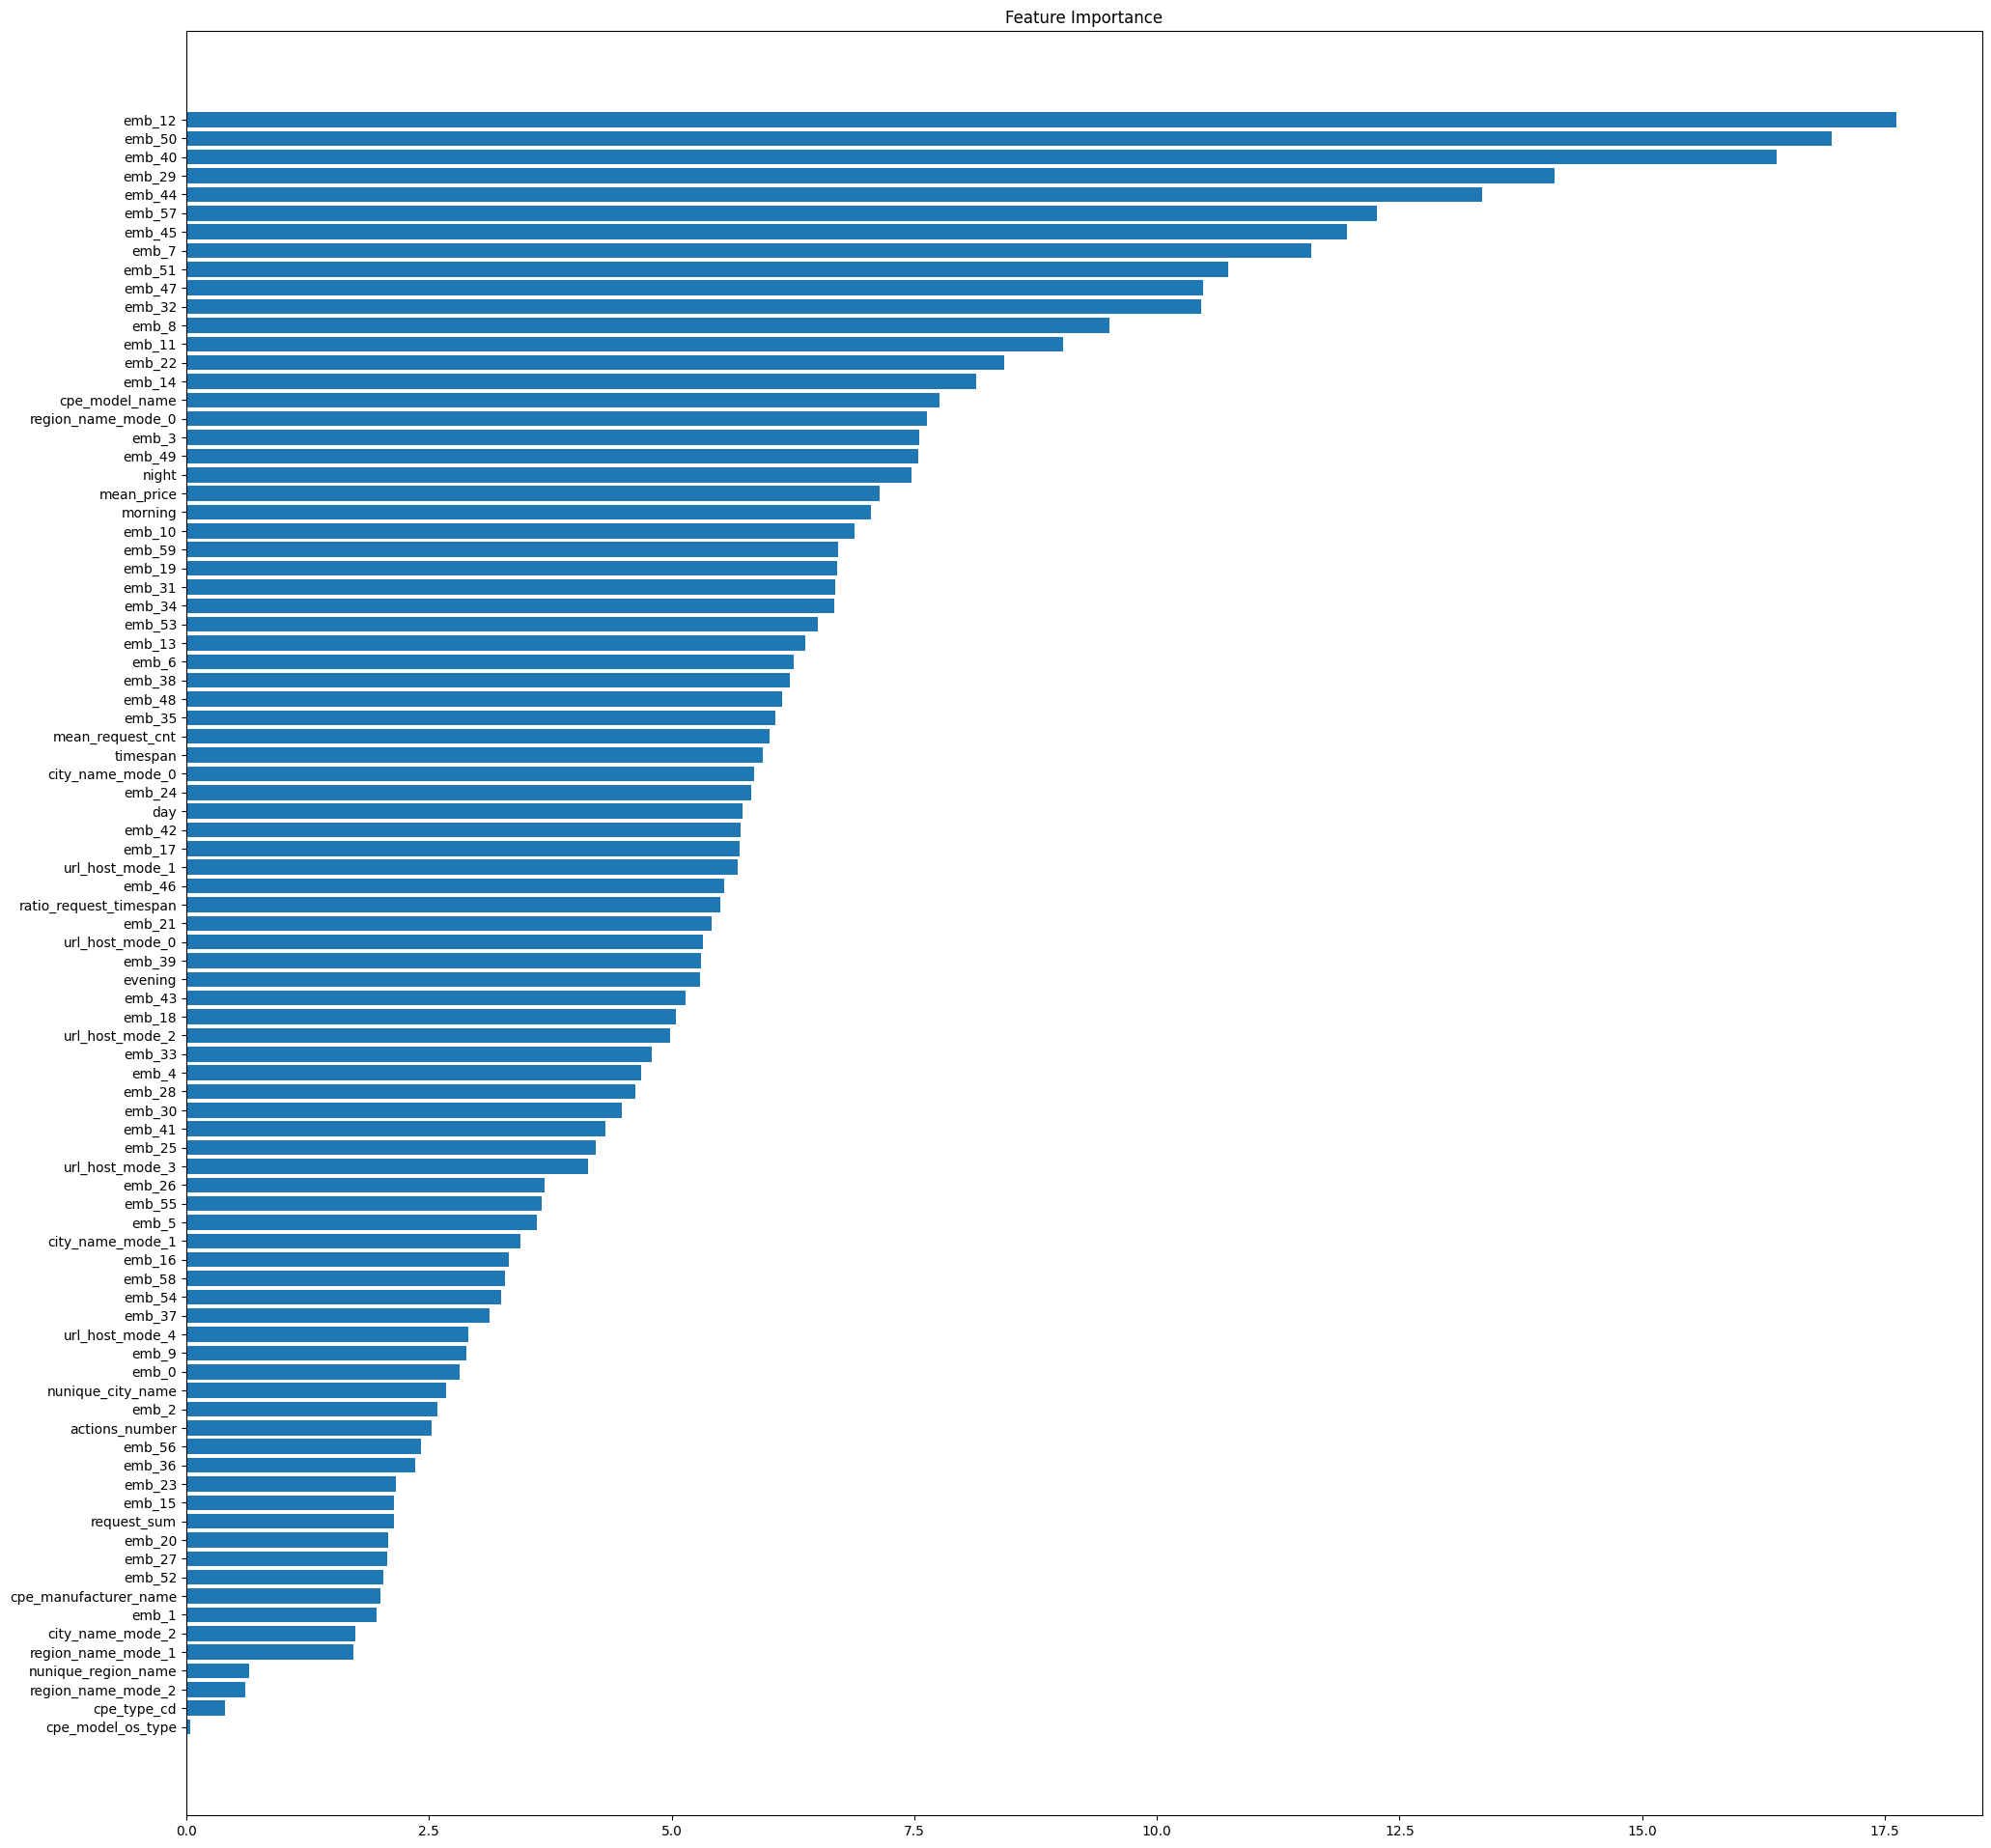

In [56]:
feature_importance = fi["Importamce"].to_numpy()
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(24, 24))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), fi["Feature Id"].to_numpy()[sorted_idx])
plt.title('Feature Importance')

In [43]:


    
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(24, 24))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features)[sorted_idx])
plt.title('Feature Importance')

SyntaxError: closing parenthesis ')' does not match opening parenthesis '{' on line 1 (3369328788.py, line 3)

# Predict

In [18]:
from catboost import Pool
from catboost import CatBoostClassifier
from catboost.utils import get_gpu_device_count

from tqdm.auto import tqdm

In [19]:
FE_DATA = "../fe_data/"
userfe = UserFE()
userfe.load(path=f"{FE_DATA}/USER_FE_v1.parquet.gzip")

userfe.df

Memory usage of dataframe is 180.61 MB


  0%|          | 0/90 [00:00<?, ?it/s]

Memory usage after optimization is: 180.61 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,request_sum,...,emb_50,emb_51,emb_52,emb_53,emb_54,emb_55,emb_56,emb_57,emb_58,emb_59
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,2261,...,0.150018,1.558850,1.005820,0.482940,0.549008,0.574814,1.135540,1.427736,-0.172871,0.229669
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,1286,...,0.041959,0.602287,0.157849,0.098895,0.696009,0.657299,0.830658,0.913854,-0.750096,0.344374
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,3306,...,-0.855035,2.063057,0.513259,-0.075544,0.196375,0.274570,1.598749,0.999600,0.500072,0.050109
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,2437,...,0.223107,1.252598,-0.523868,0.376404,-0.012564,1.590207,1.157671,1.018644,0.541227,-0.053940
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,441,...,0.816816,1.161872,0.397554,0.834156,0.331156,-0.300346,0.536354,1.105623,0.445582,-0.142890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415312,Apple,iPhone X,smartphone,iOS,375972,48.0,0.0,56357.0,690,836,...,0.787895,1.108143,0.691807,0.547904,0.495187,-0.133521,1.022638,1.505652,-0.866948,0.383678
415313,Apple,iPhone 7,smartphone,iOS,160996,NaN,NaN,26154.0,460,794,...,-0.104958,0.283250,0.819177,1.248683,-0.081512,0.770386,0.937878,0.924630,-0.577536,0.335962
415314,Huawei,P Smart Z,smartphone,Android,5505,26.0,1.0,15490.0,96,124,...,-0.138353,0.488434,0.212713,0.633304,0.681661,0.297630,0.508498,1.223274,-0.685353,0.070868
415315,Apple,iPhone SE 2020,smartphone,iOS,260127,NaN,NaN,40612.0,860,1305,...,0.563531,0.448344,0.447301,0.357191,1.903268,0.097516,1.151738,0.982791,-0.755119,0.440794


In [20]:
LOCAL_DATA = "../data"

needed_ids = pandas_reduce_mem_usage( 
        pd.read_parquet(f'{LOCAL_DATA}/submit_2.pqt')
) 
needed_ids.head()

Memory usage of dataframe is 2.21 MB


  0%|          | 0/1 [00:00<?, ?it/s]

Memory usage after optimization is: 1.66 MB
Decreased by 25.0%


,user_id
221301,221301
31271,31271
211594,211594
253119,253119
192578,192578


In [21]:
test = needed_ids.merge(userfe.df.drop(columns=["age", "is_male"]), on="user_id", how="left")
test.head()

,user_id,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,mean_price,actions_number,request_sum,url_host_mode_0,url_host_mode_1,...,emb_50,emb_51,emb_52,emb_53,emb_54,emb_55,emb_56,emb_57,emb_58,emb_59
0,221301,Apple,iPhone SE,smartphone,iOS,14381.0,564,1192,instagram.com,apple.com,...,-0.648020,0.568561,0.626261,1.319131,0.060184,0.611234,0.621542,1.796625,-0.066444,0.207421
1,31271,Samsung,Galaxy A30 Dual,smartphone,Android,12636.0,4,10,yandex.ru,yastatic.net,...,-0.056466,-0.075316,0.354259,0.285430,0.060819,0.088663,0.115732,0.702994,-0.063517,-0.147025
2,211594,Xiaomi,Poco X3 Pro,smartphone,Android,23876.0,4,7,unblock.mts.ru,googleads.g.doubleclick.net,...,0.106254,0.035513,0.072970,0.135865,-0.007194,0.148779,0.109877,0.352855,0.012993,-0.012190
3,253119,Xiaomi,Redmi 9,smartphone,Android,13133.0,14,16,i.ytimg.com,googleads.g.doubleclick.net,...,-0.264893,0.094978,0.423636,0.206551,0.089898,-0.061009,0.141727,0.887977,0.004273,-0.164617
4,192578,Apple,iPhone 7,smartphone,iOS,42009.0,143,216,apple.com,icloud.com,...,-0.390145,-0.155443,1.189710,0.868542,0.757310,-0.617199,0.381608,1.659311,-0.458176,0.744200


In [22]:
X_test = test.drop(columns=["user_id"])

In [23]:
def cross_val_predict(model_folder, df):
    test_pool = Pool(df, cat_features=np.where(df.dtypes == object)[0])
    
    model_names = os.listdir(model_folder)
    
    preds = []
    
    for model_name in tqdm(model_names):
        model = CatBoostClassifier().load_model(f"{model_folder}/{model_name}")
        pred = model.predict_proba(test_pool)
        
        preds.append(pred)
    
    return sum(preds) / len(preds)

In [24]:
age_preds = cross_val_predict("../catboost_models/age_v1", X_test).argmax(axis=1) + 1
age_preds

  0%|          | 0/5 [00:00<?, ?it/s]

array([1, 3, 2, ..., 3, 2, 3])

In [28]:
is_male_preds = cross_val_predict("../catboost_models/is_male_v1", X_test)[:, 1]
is_male_preds

  0%|          | 0/5 [00:00<?, ?it/s]

array([0.95047214, 0.51006566, 0.61034527, ..., 0.55127314, 0.75877938,
       0.5059076 ])

In [29]:
age_preds.shape, is_male_preds.shape

((144724,), (144724,))

In [30]:
needed_ids["age"] = age_preds
needed_ids["is_male"] = is_male_preds

needed_ids

,user_id,age,is_male
221301,221301,1,0.950472
31271,31271,3,0.510066
211594,211594,2,0.610345
253119,253119,3,0.672998
192578,192578,2,0.819814
...,...,...,...
145307,415284,2,0.637066
145308,415285,2,0.580288
145309,415286,3,0.551273
145312,415306,2,0.758779


In [31]:
needed_ids.to_csv("catboost_v1.csv", index=False)